In [24]:
import tensorflow as tf
import kagglehub
import shutil
import os
from google.colab import drive
from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#get latest version of dataset
path = kagglehub.dataset_download("seanscully29/flowers-classification")

print("Path to dataset files:",path)



Path to dataset files: /kaggle/input/flowers-classification


In [25]:
local_path="./flower_species_dataset"
os.makedirs(local_path, exist_ok=True)

try:
  for item in os.listdir(path):
    s = os.path.join(path,item)
    d = os.path.join(local_path,item)
    if os.path.isdir(s):
      shutil.copytree(s,d)
    else:
      shutil.copy2(s,d)
except FileExistsError:
  print(f"{local_path} already exists.")


print(f"Dataset saved at: {local_path}")


./flower_species_dataset already exists.
Dataset saved at: ./flower_species_dataset


In [26]:
source_path="/content/flower_species_dataset/flowerdataset"
training_path='./flower_species_dataset/training'
testing_path='./flower_species_dataset/testing'
classes=["black_eyed_susan","calendula","california_poppy","coreopsis","iris"]

model_path="flower_dataset_model.h5"

for cls in classes:
  os.makedirs(os.path.join(training_path,cls),exist_ok=True)
  os.makedirs(os.path.join(testing_path,cls),exist_ok=True)

for cls in classes:
  files=os.listdir(os.path.join(source_path,cls)) #Variable containing folders of each plant species from source path

  #split 65% of the images to the training set, and 35% to the testing set
  split=int(0.65 * len(files))
  training_files=files[:split]
  testing_files=files[split:]

  for t in training_files:
    shutil.move(os.path.join(source_path, cls, t),os.path.join(training_path,cls,t))
  for t in testing_files:
    shutil.move(os.path.join(source_path, cls, t),os.path.join(testing_path,cls,t))


In [27]:
# Define ImageDataGenerator for augmentation and rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_directory='/content/flower_species_dataset/training'
test_directory='/content/flower_species_dataset/testing'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training dataset
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load testing dataset
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 3059 images belonging to 5 classes.
Found 2042 images belonging to 5 classes.


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # Categorical with 5 classes
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
history=model.fit(train_generator,epochs=5,validation_data=test_generator)
model.save(model_path)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.6050 - loss: 0.8956 - val_accuracy: 0.6802 - val_loss: 0.7664
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.6484 - loss: 0.8188 - val_accuracy: 0.6562 - val_loss: 0.8148
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.6832 - loss: 0.7503 - val_accuracy: 0.7277 - val_loss: 0.6862
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.6731 - loss: 0.7432 - val_accuracy: 0.7453 - val_loss: 0.6437
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7035 - loss: 0.6651 - val_accuracy: 0.7375 - val_loss: 0.6455


Visualizing training results...


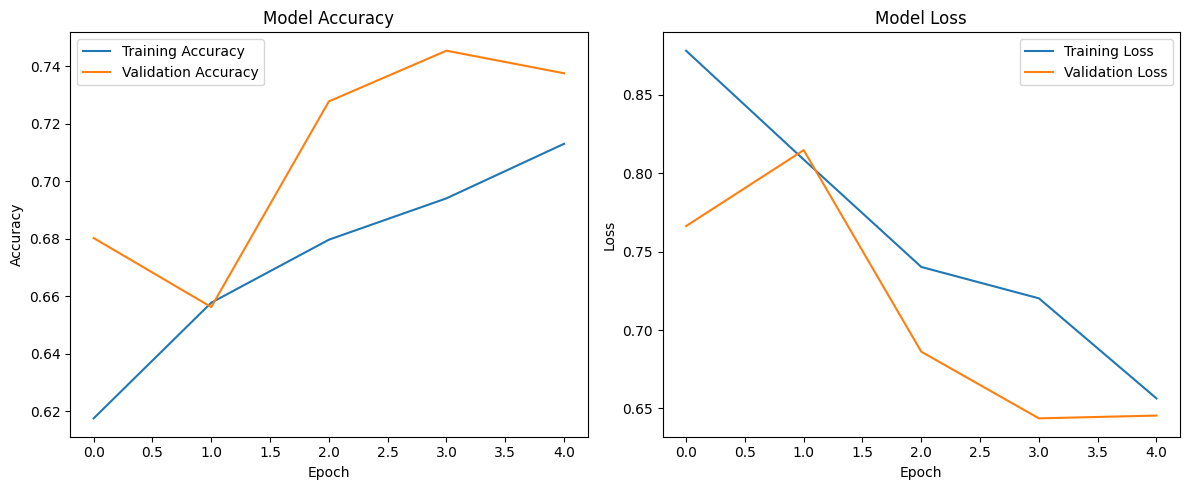

In [41]:
# === Visualization of training ===
print("Visualizing training results...")

# Plot accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os

def predict_new_image(img_path):
    model = load_model(model_path)

    # Load image in color (RGB)
    img = Image.open(img_path).convert("RGB")
    img = img.resize((150, 150))

    img_array = np.array(img).astype("float32") / 255.0
    img_array = img_array.reshape(1, 150, 150, 3)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    confidence = prediction[0][predicted_index]

    # Extract class name from the image path
    class_name = os.path.basename(os.path.dirname(img_path))

    # Display
    plt.imshow(img)
    plt.axis("off")
    # Assuming you have a 'classes' list defined somewhere with the class names
    # For example: classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    plt.title(f"Prediction: {classes[predicted_index]}, Confidence: ({confidence:.2%})")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


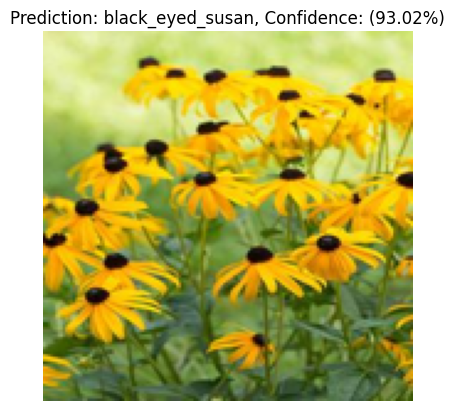

In [55]:
predict_new_image("/content/flower_species_dataset/testing/black_eyed_susan/14732404839_2b9936ff23_c.jpg")